# Project Checkpoint 2 - Research Question Results

**Contributors:** Micah Yong, Annie Lin, Bongi Fleischer, Daniel Yamada

In [1]:
# Import statements
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import arviz as avz

# Modeling 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import pymc3 as pm

# Package settings
pd.options.mode.chained_assignment = None

## Research Question 1: How well do transit ridership and infrastructure spending in the transportation sector predict GDP?

### 2.3: EDA

In this part, we will clean the monthly transportation statistics dataset and make initial observations about the data. 

First, let's narrow down the columns we're interested in using as predictors. 

In [2]:
# Load in original dataframe 
data = pd.read_csv("Monthly_Transportation_Statistics.csv")

# We want to keep track of time 
metadata_columns = ["Date", "Index"]

# We want to compute GDP. We'll keep around employment statistics as sanity checks
output_columns = ["Real Gross Domestic Product - Seasonally Adjusted"]

# We will utilize measures of transportation ridership + transportation spending 
ridership_columns = [
    "Transit Ridership - Other Transit Modes - Adjusted",
    "Transit Ridership - Fixed Route Bus - Adjusted",
    "Transit Ridership - Urban Rail - Adjusted",
    "Passenger Rail Passengers",
    "Passenger Rail Total Train Miles",
    "Passenger Rail Employee Hours Worked",
    "Transportation Services Index - Passenger",
]

spending_columns = [
    "State and Local Government Construction Spending - Transportation",
    "State and Local Government Construction Spending - Mass Transit",
    "State and Local Government Construction Spending - Total",
    "State and Local Government Construction Spending - Pavement", 
    "State and Local Government Construction Spending - Highway and Street",
    "State and Local Government Construction Spending - Automotive",
    "State and Local Government Construction Spending - Infrastructure",
]

prediction_columns = ridership_columns + spending_columns
all_columns = metadata_columns + output_columns + prediction_columns 
df = data[all_columns]

Next, we'll spend some time feature engineering. 

In [3]:
# Create effective spending columns => average spending per month from the past 4 years
df = df.dropna(subset=spending_columns)
average_spending_columns = []

for spending_feature in spending_columns:
    average_five_year_spending = spending_feature + " (Mean)"
    average_spending_columns.append(average_five_year_spending)
    df[average_five_year_spending] = df[spending_feature].rolling(4 * 12, closed="left").mean()

df = df.dropna(subset=average_spending_columns)
df = df.drop(spending_columns, axis=1)
prediction_columns = ridership_columns + average_spending_columns

In [4]:
# Drop null values
y_val = "Real Gross Domestic Product - Seasonally Adjusted"
all_columns = metadata_columns + output_columns + prediction_columns # + extra_output_columns
df = df.dropna(subset=all_columns)

In [5]:
# Computing an estimate of correlation coefficient
def correlation_coefficient_estimate(x, y):
    """Returns the Pearson Correlation Coefficient Estimate amongst non-nan entries across x and y."""
    f = df[[x, y]]
    f = f.dropna()

    return sp.stats.pearsonr(f[x], f[y])[0]

In [6]:
# Normalize columns to a common scale (z-score)
df=(df-df.mean())/df.std()

/tmp/ipykernel_354/1524244496.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df=(df-df.mean())/df.std()


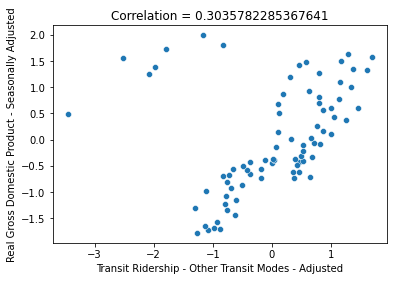

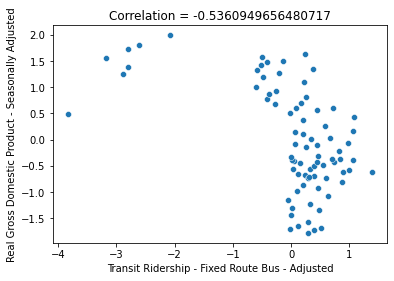

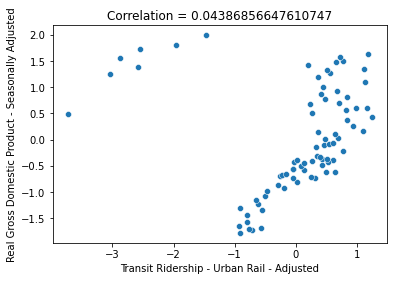

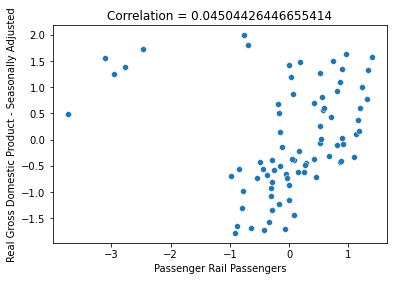

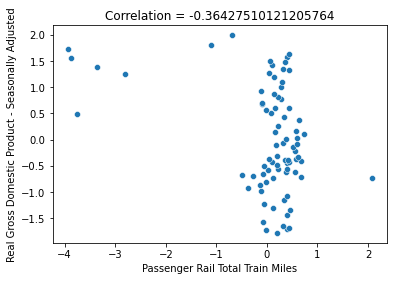

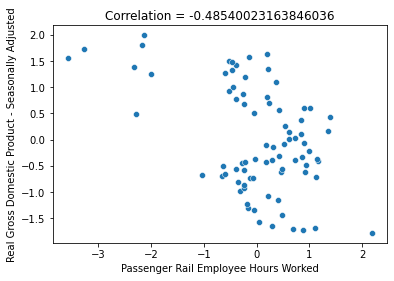

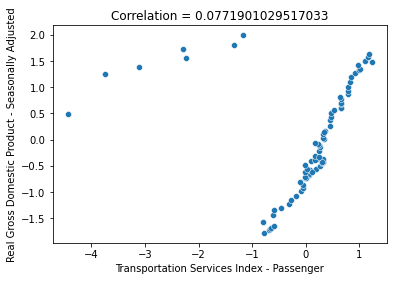

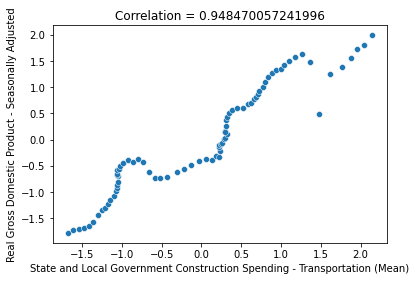

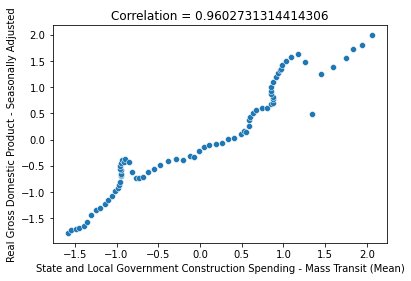

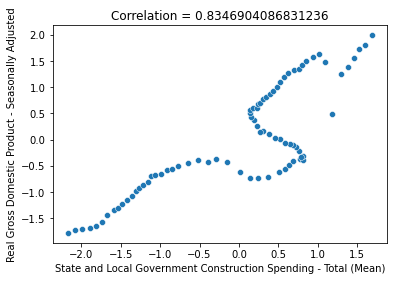

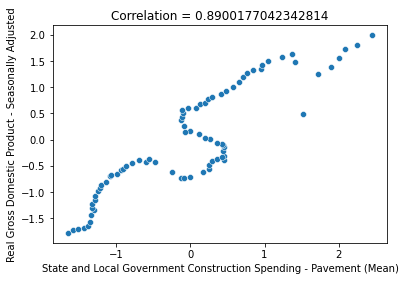

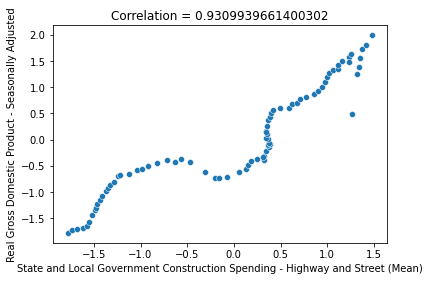

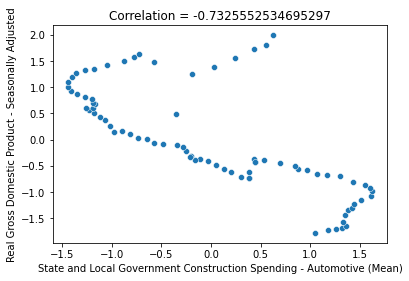

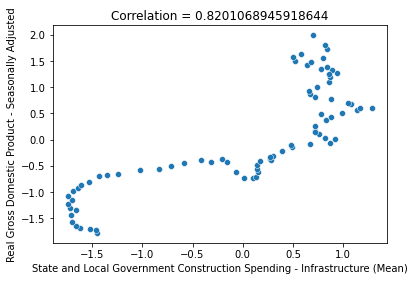

In [7]:
# Plotting and tracking correlation estimates
correlations = []

for i, feature in enumerate(prediction_columns): 
    plt.figure(i)
    r = correlation_coefficient_estimate(feature, y_val)
    correlations.append((r, feature))
    sns.scatterplot(x=df[feature], y=df[y_val]).set(title="Correlation = " + str(r))

In [8]:
# Sort and output correlations from most correlated to least
correlations.sort(reverse=True, key=lambda x: abs(x[0]))
for r, feature in correlations:
    print(feature + " : " + str(r))

State and Local Government Construction Spending - Mass Transit (Mean) : 0.9602731314414306
State and Local Government Construction Spending - Transportation (Mean) : 0.948470057241996
State and Local Government Construction Spending - Highway and Street (Mean) : 0.9309939661400302
State and Local Government Construction Spending - Pavement (Mean) : 0.8900177042342814
State and Local Government Construction Spending - Total (Mean) : 0.8346904086831236
State and Local Government Construction Spending - Infrastructure (Mean) : 0.8201068945918644
State and Local Government Construction Spending - Automotive (Mean) : -0.7325552534695297
Transit Ridership - Fixed Route Bus - Adjusted : -0.5360949656480717
Passenger Rail Employee Hours Worked : -0.48540023163846036
Passenger Rail Total Train Miles : -0.36427510121205764
Transit Ridership - Other Transit Modes - Adjusted : 0.3035782285367641
Transportation Services Index - Passenger : 0.0771901029517033
Passenger Rail Passengers : 0.045044264

To reduce effects of colinearity, we'll primarily focus on 
- "State and Local Government Construction Spending - Mass Transit (Mean)" => Spending on public transit infrastructure
- "State and Local Government Construction Spending - Automotive (Mean)" => Spending on private transit (vehicle ownership) 
- "Transit Ridership - Fixed Route Bus - Adjusted" => Usage of public transit systems (bus) 
- "Passenger Rail Passengers" => Usage of public transit systems (train) 

## 2.6: Prediction with GLMs and nonparametric models

### Frequentist Implementation using sklearn

Move this into the appendix section. 

In [10]:
# Bootstrapping the MAE for a frequentist linear regression model 
values = df.values
n_iterations = 1000
n_size = int(len(data) * 0.50) 

# run bootstrap
stats = []
for i in range(n_iterations):
    # Train, test, validation split into 60% train, 20% test, 20% split
    train, validate, test = np.split(df.sample(frac=1, replace=True), 
                       [int(.6*len(df)), int(.8*len(df))])
    
    # Linear regression
    X = train[prediction_columns].to_numpy()
    Y = train[y_val].to_numpy()

    linear_regressor = LinearRegression(positive=True)  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    
    # Fit model and evaluate MAE 
    Y_pred = linear_regressor.predict(X)  # make predictions
    stats.append(np.sqrt(metrics.mean_squared_error(Y, Y_pred)))
    
# Plotting the range of MAE
plt.hist(stats)
plt.ylabel("Frequency")
plt.xlabel("MAE")
plt.title("Distribution of Bootstrap Estimates of RMSE")

### Frequentist Implementation using statsmodels

Move into the appendix
- Here, we're using all features without VIF or consideration of interaction variables 

In [41]:
X = np.array(df[prediction_columns])
X = sm.add_constant(X) # intercept term
y = np.array(df[y_val])

# Building the model, examining key statistics 
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# Extracting RMSE
y_true = np.array(df[y_val])
y_hat = results.predict()
sm.tools.eval_measures.rmse(y_true, y_hat)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     283.8
Date:                Sun, 08 May 2022   Prob (F-statistic):           1.42e-52
Time:                        19:19:43   Log-Likelihood:                 52.159
No. Observations:                  80   AIC:                            -74.32
Df Residuals:                      65   BIC:                            -38.59
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.735e-17      0.016  -1.11e-15      1.0

### Frequentist Implementation using statsmodels
- We will be using this in our final analysis

In [112]:
# Manually construct linear regression skeleton

# Rename dataframe columns (Pymc3 doesn't allow attribute names with spaces)
rename_dict = {y_val: 'y'}
for i, col in enumerate(prediction_columns): 
    rename_dict[col] = "x" + str(i)
renamed_df = df.rename(columns=rename_dict).drop(columns=metadata_columns)

In [113]:
# Removing dependent variables using the VIF (similar to PCA)
def calculate_vif_(X, thresh=7.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

prediction_columns_wo_colinearity = calculate_vif_(renamed_df)

dropping 'x7' at index: 10
dropping 'x11' at index: 5
dropping 'x2' at index: 11
dropping 'x10' at index: 7
dropping 'y' at index: 3
dropping 'x0' at index: 8
dropping 'x13' at index: 4
dropping 'x8' at index: 4
dropping 'x6' at index: 6
Remaining variables:
Index(['x5', 'x3', 'x4', 'x12', 'x9', 'x1'], dtype='object')


In [114]:
# Compute formula with only the non-colinear variables
formula = f'y ~ ' + ' + '.join(prediction_columns_wo_colinearity)
print(formula)

# Construct model from formula 
glm_ = smf.glm(formula=formula,
              data=renamed_df,
              family=sm.families.Gaussian())
glm = glm_.fit()
glm.summary() # Passes pearson chi_squared test, but not log likelihood test => Indicates decent fit 

y ~ x5 + x3 + x4 + x12 + x9 + x1


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   80
Model:                            GLM   Df Residuals:                       73
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                         0.10561
Method:                          IRLS   Log-Likelihood:                -19.932
Date:                Sun, 08 May 2022   Deviance:                       7.7095
Time:                        20:41:48   Pearson chi2:                     7.71
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.735e-17      0.036  -4.77e-16      1.000      -0.071       0.071
x5            -0.5096      0.072     -7.045      0.000      -0.651      -0.368
x3             0.2626      0.080      3.283      0.001       0.106       0.419
x4            -0.0388      0.089     -0.435      0.663      -0.213       0.136
x12           -0.4843      0.066     -7.316      0.000      -0.614      -0.355
x9             0.2614      0.064      4.099      0.000       0.136       0.386
x1            -0.1047      0.083     -1.269      0.205      -0.266       0.057
==============================================================================
"""

In [115]:
# Extracting RMSE
y_true = np.array(df[y_val])
y_hat = glm.predict()
sm.tools.eval_measures.rmse(y_true, y_hat)

0.3104326375762173

In [135]:
# TODO: Repeat above analysis with bootstrap to construct confidence interval 

### Bayesian implementation using Pymc3

In [116]:
# We can reuse the formula derived in the frequentist approach to construct a Bayesian GLM
print(formula)

bglm = pm.Model()
with bglm:
    # Normally distributed priors
    family = pm.glm.families.Normal()
    # create the model 
    pm.GLM.from_formula(formula,data=renamed_df,family=family)
    # sample
    trace = pm.sample(1000,return_inferencedata=True)

summary = avz.summary(trace)
summary

y ~ x5 + x3 + x4 + x12 + x9 + x1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x1, x9, x12, x4, x3, x5, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.000,0.037,-0.071,0.069,0.001,0.001,4386.0,2337.0,1.0
x5,-0.511,0.071,-0.643,-0.372,0.001,0.001,3692.0,2833.0,1.0
x3,0.265,0.079,0.119,0.418,0.001,0.001,3526.0,3198.0,1.0
x4,-0.040,0.088,-0.201,0.130,0.001,0.001,3465.0,2272.0,1.0
x12,-0.484,0.068,-0.600,-0.349,0.001,0.001,3356.0,2679.0,1.0
x9,0.260,0.067,0.144,0.400,0.001,0.001,3493.0,2535.0,1.0
x1,-0.105,0.084,-0.257,0.052,0.001,0.001,3504.0,2728.0,1.0
sd,0.330,0.028,0.280,0.380,0.000,0.000,3476.0,2461.0,1.0


In [117]:
# Draw posterior predictive samples from linear model 
with bglm:
    gaussian_ppc = pm.sample_posterior_predictive(
        trace, var_names=list(prediction_columns_wo_colinearity.columns) + ['y'] + ['Intercept']
    )

/opt/conda/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/lib/python3.9/site-packages/arviz/plots/hdip

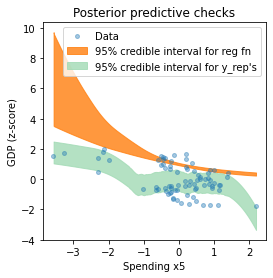

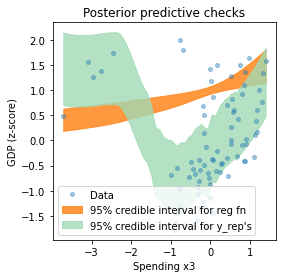

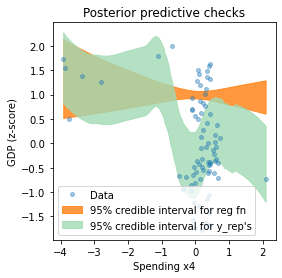

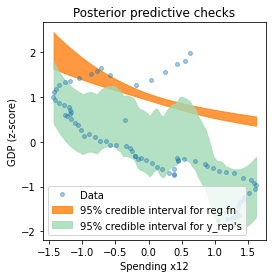

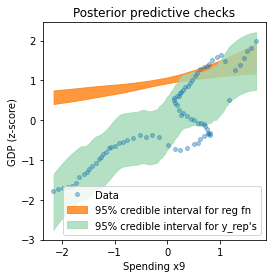

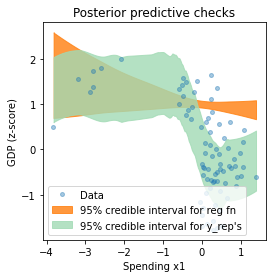

In [129]:
# Perform posterior predictive checking across all features

for col in list(prediction_columns_wo_colinearity.columns):
    # Compute the posterior regression function (y hat values) for the linear GLM
    y_hat_gaussian = np.exp(
        np.outer(gaussian_ppc[col], prediction_columns_wo_colinearity[col])
        + gaussian_ppc["Intercept"][:,np.newaxis]
    )
    
    # Plot posterior predictive checks, construct credible interval 
    _, ax = plt.subplots(figsize = (4,4))

    ax.plot(prediction_columns_wo_colinearity[col], df[y_val], "o", ms=4, alpha=0.4, label="Data")
    avz.plot_hdi(
        prediction_columns_wo_colinearity[col],
        y_hat_gaussian,
        ax=ax,
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.8, "label": "95% credible interval for reg fn"},
    )
    avz.plot_hdi(
        prediction_columns_wo_colinearity[col],
        gaussian_ppc["y"],
        ax=ax,
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "95% credible interval for y_rep's"},
    )

    ax.set_xlabel(f"Spending {col}")
    ax.set_ylabel("GDP (z-score)")
    ax.set_title("Posterior predictive checks")
    ax.legend(fontsize=10);

### Results

**Summarize and interpret the results from your models.**

The value of the root mean squared error for our linear model predicting GDP is 148079048578.94388, which translates to an average difference of around $148 billion between the observed values and predicted values of GDP. Based on the values of GDP within the dataset, we know that the units of measure are usually in the 10-20 trillions range, so seeing such a large number for the MAE of our model is not surprising.

**Estimate any uncertainty in your GLM predictions, providing clear quantitative statements of the uncertainty in plain English.**

### Part 3: Building a neural network to predict GDP 

In [ ]:
# Import statements
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import sgd_experimental

# Package settings
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error 

In [ ]:
# Prepare Data 
df_nn = df.drop(metadata_columns, axis=1)
dataset = df_nn.values
X = dataset[:, 1:] # columns after 1st col are the input features (16 features)
Y = dataset[:,0:1] # 1st col (real GDP) is feature we want to predict 

# Split data into train, test, and validation 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [ ]:
# Set up model hyperparameters
NN_model = Sequential()

# The Input Layer : Takes in k features with a relu (nonlinear) activation function
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers : To model interaction variables and more 
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer : Return an estimate for real GDP
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network 
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

In [ ]:
# Fit model to training data (segmenting a portion for validation)
NN_model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

In [ ]:
NN_model.evaluate(X_test, Y_test)